In [1]:
import numpy as np
from tifffile import imread 
from pathlib import Path
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from stardist import fill_label_holes
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import  normalized_root_mse as mse
import numpy as np

from numba import jit
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import namedtuple
from csbdeep.utils import _raise

In [2]:
GT = sorted(glob('/Users/aimachine/Downloads/CellTracking/officialexample/GreenCellsMetric/GT/*.tif'))
StarDist = sorted(glob('/Users/aimachine/Downloads/CellTracking/officialexample/GreenCellsMetric/Star/*.tif'))
VollSeg = sorted(glob('/Users/aimachine/Downloads/CellTracking/officialexample/GreenCellsMetric/Voll/*.tif'))
BinarySeg = sorted(glob('/Users/aimachine/Downloads/CellTracking/officialexample/GreenCellsMetric/Binary/*.tif'))
Results = '/Users/aimachine/Downloads/CellTracking/officialexample/GreenCellsMetric/Results/'
GT = list(map(imread,GT))
StarDist = list(map(imread,StarDist))
VollSeg = list(map(imread,VollSeg))
BinarySeg = list(map(imread,BinarySeg))
GT = [y for y in tqdm(GT)]
StarDist = [y for y in tqdm(StarDist)]
VollSeg = [y for y in tqdm(VollSeg)]
BinarySeg = [y for y in tqdm(BinarySeg)]

100%|██████████| 7/7 [00:00<00:00, 2355.22it/s]


In [3]:
Vollmse = []
Starmse = []
Binmse = []
for i in range(len(VollSeg)):
    similarity = mse(VollSeg[i],GT[i])
    Vollmse.append(similarity)
    similarity = mse(StarDist[i],GT[i])
    Starmse.append(similarity)
    similarity = mse(BinarySeg[i],GT[i])
    Binmse.append(similarity)

In [4]:
matching_criteria = dict()

def label_are_sequential(y):
    """ returns true if y has only sequential labels from 1... """
    labels = np.unique(y)
    return (set(labels)-{0}) == set(range(1,1+labels.max()))


def is_array_of_integers(y):
    return isinstance(y,np.ndarray) and np.issubdtype(y.dtype, np.integer)


def _check_label_array(y, name=None, check_sequential=False):
    err = ValueError("{label} must be an array of {integers}.".format(
        label = 'labels' if name is None else name,
        integers = ('sequential ' if check_sequential else '') + 'non-negative integers',
    ))
    is_array_of_integers(y) or _raise(err)
    if check_sequential:
        label_are_sequential(y) or _raise(err)
    else:
        y.min() >= 0 or _raise(err)
    return True


def label_overlap(x, y, check=True):
    if check:
        _check_label_array(x,'x',True)
        _check_label_array(y,'y',True)
        x.shape == y.shape or _raise(ValueError("x and y must have the same shape"))
    return _label_overlap(x, y)

@jit(nopython=True)
def _label_overlap(x, y):
    x = x.ravel()
    y = y.ravel()
    overlap = np.zeros((1+x.max(),1+y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1
    return overlap

def get_ssim(x,y):
    
    similarity = mse(x,y)
    
    return similarity
def intersection_over_union(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / (n_pixels_pred + n_pixels_true - overlap)

matching_criteria['iou'] = intersection_over_union


def intersection_over_true(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / n_pixels_true

matching_criteria['iot'] = intersection_over_true


def intersection_over_pred(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    return overlap / n_pixels_pred

matching_criteria['iop'] = intersection_over_pred


def precision(tp,fp,fn):
    return tp/(tp+fp) if tp > 0 else 0
def recall(tp,fp,fn):
    return tp/(tp+fn) if tp > 0 else 0
def accuracy(tp,fp,fn):
    # also known as "average precision" (?)
    # -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
    return tp/(tp+fp+fn) if tp > 0 else 0
def f1(tp,fp,fn):
    # also known as "dice coefficient"
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


def _safe_divide(x,y):
    return x/y if y>0 else 0.0

def matching(y_true, y_pred, thresh=0.5, criterion='iot', report_matches=False):
    """Calculate detection/instance segmentation metrics between ground truth and predicted label images.
    Currently, the following metrics are implemented:
    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'
    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)
    * mean_matched_score is the mean IoUs of matched true positives
    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects
    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019
    Parameters
    ----------
    y_true: ndarray
        ground truth label image (integer valued)
        predicted label image (integer valued)
    thresh: float
        threshold for matching criterion (default 0.5)
    criterion: string
        matching criterion (default IoU)
    report_matches: bool
        if True, additionally calculate matched_pairs and matched_scores (note, that this returns even gt-pred pairs whose scores are below  'thresh')
    Returns
    -------
    Matching object with different metrics as attributes
    Examples
    --------
    >>> y_true = np.zeros((100,100), np.uint16)
    >>> y_true[10:20,10:20] = 1
    >>> y_pred = np.roll(y_true,5,axis = 0)
    >>> stats = matching(y_true, y_pred)
    >>> print(stats)
    Matching(criterion='iou', thresh=0.5, fp=1, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=1, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0)
    """
    _check_label_array(y_true,'y_true')
    _check_label_array(y_pred,'y_pred')
    y_true.shape == y_pred.shape or _raise(ValueError("y_true ({y_true.shape}) and y_pred ({y_pred.shape}) have different shapes".format(y_true=y_true, y_pred=y_pred)))
    criterion in matching_criteria or _raise(ValueError("Matching criterion '%s' not supported." % criterion))
    if thresh is None: thresh = 0
    thresh = float(thresh) if np.isscalar(thresh) else map(float,thresh)

    y_true, _, map_rev_true = relabel_sequential(y_true)
    y_pred, _, map_rev_pred = relabel_sequential(y_pred)

    overlap = label_overlap(y_true, y_pred, check=False)
    normalized_root_mse = get_ssim(y_true, y_pred)
    scores = matching_criteria[criterion](overlap)
    assert 0 <= np.min(scores) <= np.max(scores) <= 1

    # ignoring background
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    def _single(thr):
        not_trivial = n_matched > 0 and np.any(scores >= thr)
        if not_trivial:
            # compute optimal matching with scores as tie-breaker
            costs = -(scores >= thr).astype(float) - scores / (2*n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            assert n_matched == len(true_ind) == len(pred_ind)
            match_ok = scores[true_ind,pred_ind] >= thr
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        fp = n_pred - tp
        fn = n_true - tp
        # assert tp+fp == n_pred
        # assert tp+fn == n_true

        # the score sum over all matched objects (tp)
        sum_matched_score = np.sum(scores[true_ind,pred_ind][match_ok]) if not_trivial else 0.0

        # the score average over all matched objects (tp)
        mean_matched_score = _safe_divide(sum_matched_score, tp)
        # the score average over all gt/true objects
        mean_true_score    = _safe_divide(sum_matched_score, n_true)
        panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

        stats_dict = dict (
            criterion          = criterion,
            thresh             = thr,
            fp                 = fp,
            tp                 = tp,
            fn                 = fn,
            precision          = precision(tp,fp,fn),
            recall             = recall(tp,fp,fn),
            accuracy           = accuracy(tp,fp,fn),
            f1                 = f1(tp,fp,fn),
            n_true             = n_true,
            n_pred             = n_pred,
            mean_true_score    = mean_true_score,
            mean_matched_score = mean_matched_score,
            panoptic_quality   = panoptic_quality,
            normalized_root_mse = normalized_root_mse,
        )
        if bool(report_matches):
            if not_trivial:
                stats_dict.update (
                    # int() to be json serializable
                    matched_pairs  = tuple((int(map_rev_true[i]),int(map_rev_pred[j])) for i,j in zip(1+true_ind,1+pred_ind)),
                    matched_scores = tuple(scores[true_ind,pred_ind]),
                    matched_tps    = tuple(map(int,np.flatnonzero(match_ok))),
                )
            else:
                stats_dict.update (
                    matched_pairs  = (),
                    matched_scores = (),
                    matched_tps    = (),
                )
        return namedtuple('Matching',stats_dict.keys())(*stats_dict.values())

    return _single(thresh) if np.isscalar(thresh) else tuple(map(_single,thresh))



def matching_dataset(y_true, y_pred, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):
    """matching metrics for list of images, see `stardist.matching.matching`
    """
    len(y_true) == len(y_pred) or _raise(ValueError("y_true and y_pred must have the same length."))
    return matching_dataset_lazy (
        tuple(zip(y_true,y_pred)), thresh=thresh, criterion=criterion, by_image=by_image, show_progress=show_progress, parallel=parallel,
    )



def matching_dataset_lazy(y_gen, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):

    expected_keys = set(('fp', 'tp', 'fn', 'normalized_root_mse', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'))
    single_thresh = False
    if np.isscalar(thresh):
        single_thresh = True
        thresh = (thresh,)

    tqdm_kwargs = {}
    tqdm_kwargs['disable'] = not bool(show_progress)
    if int(show_progress) > 1:
        tqdm_kwargs['total'] = int(show_progress)

    # compute matching stats for every pair of label images
    if parallel:
        from concurrent.futures import ThreadPoolExecutor
        fn = lambda pair: matching(*pair, thresh=thresh, criterion=criterion, report_matches=False)
        with ThreadPoolExecutor() as pool:
            stats_all = tuple(pool.map(fn, tqdm(y_gen,**tqdm_kwargs)))
    else:
        stats_all = tuple (
            matching(y_t, y_p, thresh=thresh, criterion=criterion, report_matches=False)
            for y_t,y_p in tqdm(y_gen,**tqdm_kwargs)
        )

    # accumulate results over all images for each threshold separately
    n_images, n_threshs = len(stats_all), len(thresh)
    accumulate = [{} for _ in range(n_threshs)]
    for stats in stats_all:
        for i,s in enumerate(stats):
            acc = accumulate[i]
            for k,v in s._asdict().items():
                if k == 'mean_true_score' and not bool(by_image):
                    # convert mean_true_score to "sum_matched_score"
                    acc[k] = acc.setdefault(k,0) + v * s.n_true
                else:
                    try:
                        acc[k] = acc.setdefault(k,0) + v
                    except TypeError:
                        pass
    # normalize/compute 'precision', 'recall', 'accuracy', 'f1'
    for thr,acc in zip(thresh,accumulate):
        set(acc.keys()) == expected_keys or _raise(ValueError("unexpected keys"))
        acc['criterion'] = criterion
        acc['thresh'] = thr
        acc['by_image'] = bool(by_image)
        if bool(by_image):
            for k in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
                acc[k] /= n_images
        else:
            tp, fp, fn, n_true, normalized_root_mse = acc['tp'], acc['fp'], acc['fn'], acc['n_true'], acc['normalized_root_mse']
            sum_matched_score = acc['mean_true_score']

            mean_matched_score = _safe_divide(sum_matched_score, tp)
            mean_true_score    = _safe_divide(sum_matched_score, n_true)
            panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

            acc.update(
                precision          = precision(tp,fp,fn),
                recall             = recall(tp,fp,fn),
                accuracy           = accuracy(tp,fp,fn),
                f1                 = f1(tp,fp,fn),
                mean_true_score    = mean_true_score,
                mean_matched_score = mean_matched_score,
                panoptic_quality   = panoptic_quality,
                normalized_root_mse = normalized_root_mse,
            )

    accumulate = tuple(namedtuple('DatasetMatching',acc.keys())(*acc.values()) for acc in accumulate)
    return accumulate[0] if single_thresh else accumulate



# copied from scikit-image master for now (remove when part of a release)
def relabel_sequential(label_field, offset=1):
    """Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.
    This function also returns the forward map (mapping the original labels to
    the reduced labels) and the inverse map (mapping the reduced labels back
    to the original ones).
    Parameters
    ----------
    label_field : numpy array of int, arbitrary shape
        An array of labels, which must be non-negative integers.
    offset : int, optional
        The return labels will start at `offset`, which should be
        strictly positive.
    Returns
    -------
    relabeled : numpy array of int, same shape as `label_field`
        The input label field with labels mapped to
        {offset, ..., number_of_labels + offset - 1}.
        The data type will be the same as `label_field`, except when
        offset + number_of_labels causes overflow of the current data type.
    forward_map : numpy array of int, shape ``(label_field.max() + 1,)``
        The map from the original label space to the returned label
        space. Can be used to re-apply the same mapping. See examples
        for usage. The data type will be the same as `relabeled`.
    inverse_map : 1D numpy array of int, of length offset + number of labels
        The map from the new label space to the original space. This
        can be used to reconstruct the original label field from the
        relabeled one. The data type will be the same as `relabeled`.
    Notes
    -----
    The label 0 is assumed to denote the background and is never remapped.
    The forward map can be extremely big for some inputs, since its
    length is given by the maximum of the label field. However, in most
    situations, ``label_field.max()`` is much smaller than
    ``label_field.size``, and in these cases the forward map is
    guaranteed to be smaller than either the input or output images.
    Examples
    --------
    >>> from skimage.segmentation import relabel_sequential
    >>> label_field = np.array([1, 1, 5, 5, 8, 99, 42])
    >>> relab, fw, inv = relabel_sequential(label_field)
    >>> relab
    array([1, 1, 2, 2, 3, 5, 4])
    >>> fw
    array([0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])
    >>> inv
    array([ 0,  1,  5,  8, 42, 99])
    >>> (fw[label_field] == relab).all()
    True
    >>> (inv[relab] == label_field).all()
    True
    >>> relab, fw, inv = relabel_sequential(label_field, offset=5)
    >>> relab
    array([5, 5, 6, 6, 7, 9, 8])
    """
    offset = int(offset)
    if offset <= 0:
        raise ValueError("Offset must be strictly positive.")
    if np.min(label_field) < 0:
        raise ValueError("Cannot relabel array that contains negative values.")
    max_label = int(label_field.max()) # Ensure max_label is an integer
    if not np.issubdtype(label_field.dtype, np.integer):
        new_type = np.min_scalar_type(max_label)
        label_field = label_field.astype(new_type)
    labels = np.unique(label_field)
    labels0 = labels[labels != 0]
    new_max_label = offset - 1 + len(labels0)
    new_labels0 = np.arange(offset, new_max_label + 1)
    output_type = label_field.dtype
    required_type = np.min_scalar_type(new_max_label)
    if np.dtype(required_type).itemsize > np.dtype(label_field.dtype).itemsize:
        output_type = required_type
    forward_map = np.zeros(max_label + 1, dtype=output_type)
    forward_map[labels0] = new_labels0
    inverse_map = np.zeros(new_max_label + 1, dtype=output_type)
    inverse_map[offset:] = labels0
    relabeled = forward_map[label_field]
    return relabeled, forward_map, inverse_map


In [5]:

taus = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
statsStar = [matching_dataset(GT, StarDist, thresh=t, show_progress=False) for t in tqdm(taus)]
statsVoll = [matching_dataset(GT, VollSeg, thresh=t, show_progress=False) for t in tqdm(taus)]
statsUnet = [matching_dataset(GT, BinarySeg, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


# StarDist metrics

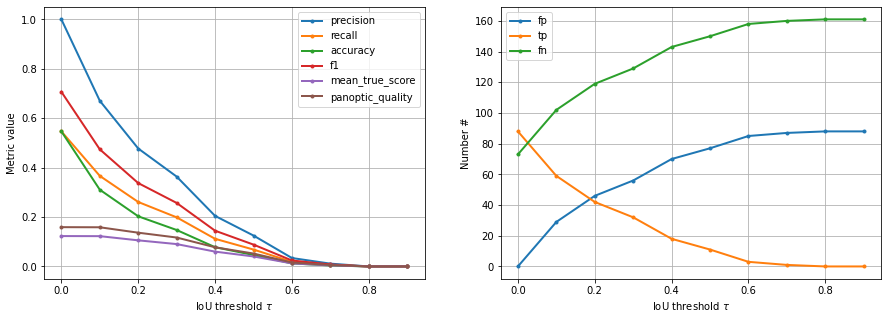

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score','panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in statsStar], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in statsStar], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
plt.savefig(Results + 'Star')

# VollSeg metrics

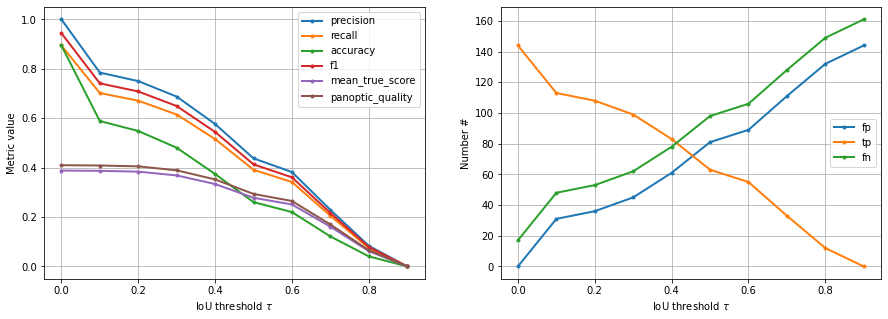

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in statsVoll], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in statsVoll], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
plt.savefig(Results + 'VollSeg')

# Unet metrics

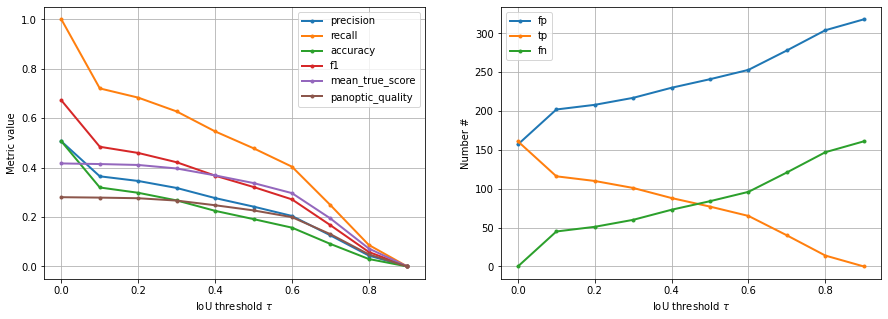

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score','panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in statsUnet], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in statsUnet], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
plt.savefig(Results + 'Unet')

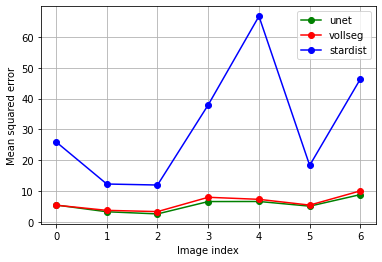

In [9]:
plt.plot(Binmse, '-og', label = "unet")
plt.plot(Vollmse, '-or', label = "vollseg")
plt.plot(Starmse, '-ob', label = "stardist")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Image index')
plt.ylabel('Mean squared error')
plt.savefig(Results + 'MSE')

In [10]:
from stardist.matching import matching
help(matching)

Help on function matching in module stardist.matching:

matching(y_true, y_pred, thresh=0.5, criterion='iou', report_matches=False)
    Calculate detection/instance segmentation metrics between ground truth and predicted label images.
    
    Currently, the following metrics are implemented:
    
    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'
    
    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)
    
    * mean_matched_score is the mean IoUs of matched true positives
    
    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects
    
    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019
    